In [213]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from google.cloud import storage
from tqdm import tqdm
storage_client = storage.Client()
bucket = storage_client.get_bucket('ah21_data')

In [214]:
import seaborn as sns
sns.set_style("dark")
sns.despine()

<Figure size 432x288 with 0 Axes>

In [313]:

def compute_averages_over_many_seeds(experiment_path, seed_subset=(0,100), verbose=False):
    
    potential_blobs = [str(blob).split()[2][:-1] for blob in storage_client.list_blobs(bucket,prefix=experiment_path)]
    seed_blobs = [blob for blob in potential_blobs if blob[-13:] == 'save/logs.txt'] 

    if verbose: 
        for i in seed_blobs:
            print(">", "/".join(i.split("/")[-3:]))
        
    sorted_seed_blobs = []
    for i in range(seed_subset[0], seed_subset[1]):
        for s in seed_blobs:
            if int(s.split("/")[-3].replace("seed_","")) == i:
                sorted_seed_blobs.append(s)
    print("number of sorted blobs = ", len(sorted_seed_blobs))

    if len(sorted_seed_blobs) == 0: return

    seed_dictionaries = {}
    n_models = 7
    for ind, seed in enumerate(tqdm(sorted_seed_blobs)):

        blob = bucket.get_blob(seed)
        s = int(seed.split("/")[-3].replace("seed_",""))
        content = blob.download_as_string().decode('UTF-8').splitlines()
        tasks = [content[i-1] for i, c in enumerate(content) if '<openfl.component.aggregation_functions.weighted_average.WeightedAverage object at' in c][1::n_models]
        content = [c.split(">")[1][1:] for c in content if '<openfl.component.aggregation_functions.weighted_average.WeightedAverage object at' in c][1:]

        ## create a list of n_models*n_tasks tasks in the correct order as they appear in the tasks heading list (differs per seed)
        cnt = 0
        openfl_tasks = []
        for j in range(len(tasks)):
            t = [tasks[cnt] for model in range(n_models)]
            openfl_tasks.extend(t)
            cnt+=1    

        value_dictionary = {}
        for i, word in enumerate(content):
            task = openfl_tasks[i]
            key = task.replace(" task metrics...","")+"_"+word.split(":")[0]
            value = float(word.split(":")[1].replace("\t",""))

            if key in value_dictionary.keys():
                value_dictionary[key].append(value)
            else:
                value_dictionary[key] = [value]

        seed_dictionaries[s] = value_dictionary

    keys = list(seed_dictionaries[s].keys())
    keys.sort(reverse=False)

    if verbose: print(">", tasks[:10])
    if verbose: print(">", keys)
    if verbose: print(">", seed_dictionaries.keys())
    mean_dictionary, std_dictionary, array_dictionary = {}, {}, {}
    for key in keys:
        if verbose: print("key=", key)
        if verbose: print([seed_dictionaries[s][key] for s in seed_dictionaries.keys()])
        mean_dictionary[key]  = np.abs(np.mean( [seed_dictionaries[s][key] for s in seed_dictionaries.keys()], axis=0))
        std_dictionary[key]   = np.std(  [seed_dictionaries[s][key] for s in seed_dictionaries.keys()], axis = 0)
        array_dictionary[key] = np.array([seed_dictionaries[s][key] for s in seed_dictionaries.keys()] )

    return mean_dictionary, std_dictionary, keys

In [216]:
def plot_separate_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches=100):
    nrows = 3 # different metrics
    ncols = 7 # different models
    fig, ax = plt.subplots(nrows, ncols, figsize=(25,14))

    ind = 0
    for i in range(nrows): 
        ymax = np.max([ np.max(mean_dictionary[key]) for key in keys])
        for j in range(ncols):       
            key = keys[ind]

            ind +=1
            x = np.linspace(1, consistent_n_batches, consistent_n_batches)
            y = mean_dictionary[key]

            ci = 1.96 * std_dictionary[key]

            l = key.replace("model_validation","").replace("ly_tuned","").replace("regated_", "").replace("model_","").replace("train_IRM_","")
            ax[i][j].plot(x,y, label=l)
            ax[i][j].fill_between(x, (y-ci), (y+ci), color='b', alpha=.05)
            ax[i][j].set_ylim(0, ymax *2)
            ax[i][j].legend()

In [277]:
def plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches=100, metric = "MSE"):
    nrows = 3 # different metrics
    
    ncols = 7 # different models
    fig, ax = plt.subplots(1, nrows, figsize=(35,12))

    ind = 0
      
    titles = ["Validate: Aggregate Model", "Validate: Local Model", "Training: Loss"]
    yaxes= [metric, metric, "Cross Enropy"]
    for i in range(nrows): 
        for j in range(ncols):   
            key = keys[ind]
            ind +=1
            x = np.linspace(1, consistent_n_batches, consistent_n_batches)
            y = mean_dictionary[key]

            ci = 1.96 * std_dictionary[key]

            l = key.replace("model_validation","").replace("ly_tuned","").replace("regated_", "").replace("model_","").replace("train_IRM_","").split("_")[-1]
            ax[i].plot(x,y, label=l)
            ax[i].fill_between(x, (y-ci), (y+ci), color='b', alpha=.015)
            ax[i].legend()
            ax[i].set_title(titles[i])
            #ax[i].set_xlabel("epochs (x 30)")
            ax[i].set_xlabel("epochs")
            ax[i].set_ylabel(yaxes[i])
    plt.plot()

## Presentation Experiments: 1d and 2d: 1 epoch per round.

In [314]:
presentation_runner = {
"1d": ("validation/Example1_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_900_n_env_5/", "MSE"),
"2d": ("validation/Example2_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_900_n_env_5/", "CCR"),
#"con": ("validation/Example_Confounder_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_900_n_env_5/", "MSE")
}


In [ ]:
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds("validation/Example1_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_900_n_env_5/", (90,100), verbose = True)
plot_graphs(mean_dictionary, std_dictionary, keys, 200, "MSE")

  0%|          | 0/3 [00:00<?, ?it/s]

number of sorted blobs =  3


  0%|          | 0/3 [00:00<?, ?it/s]

number of sorted blobs =  3


100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


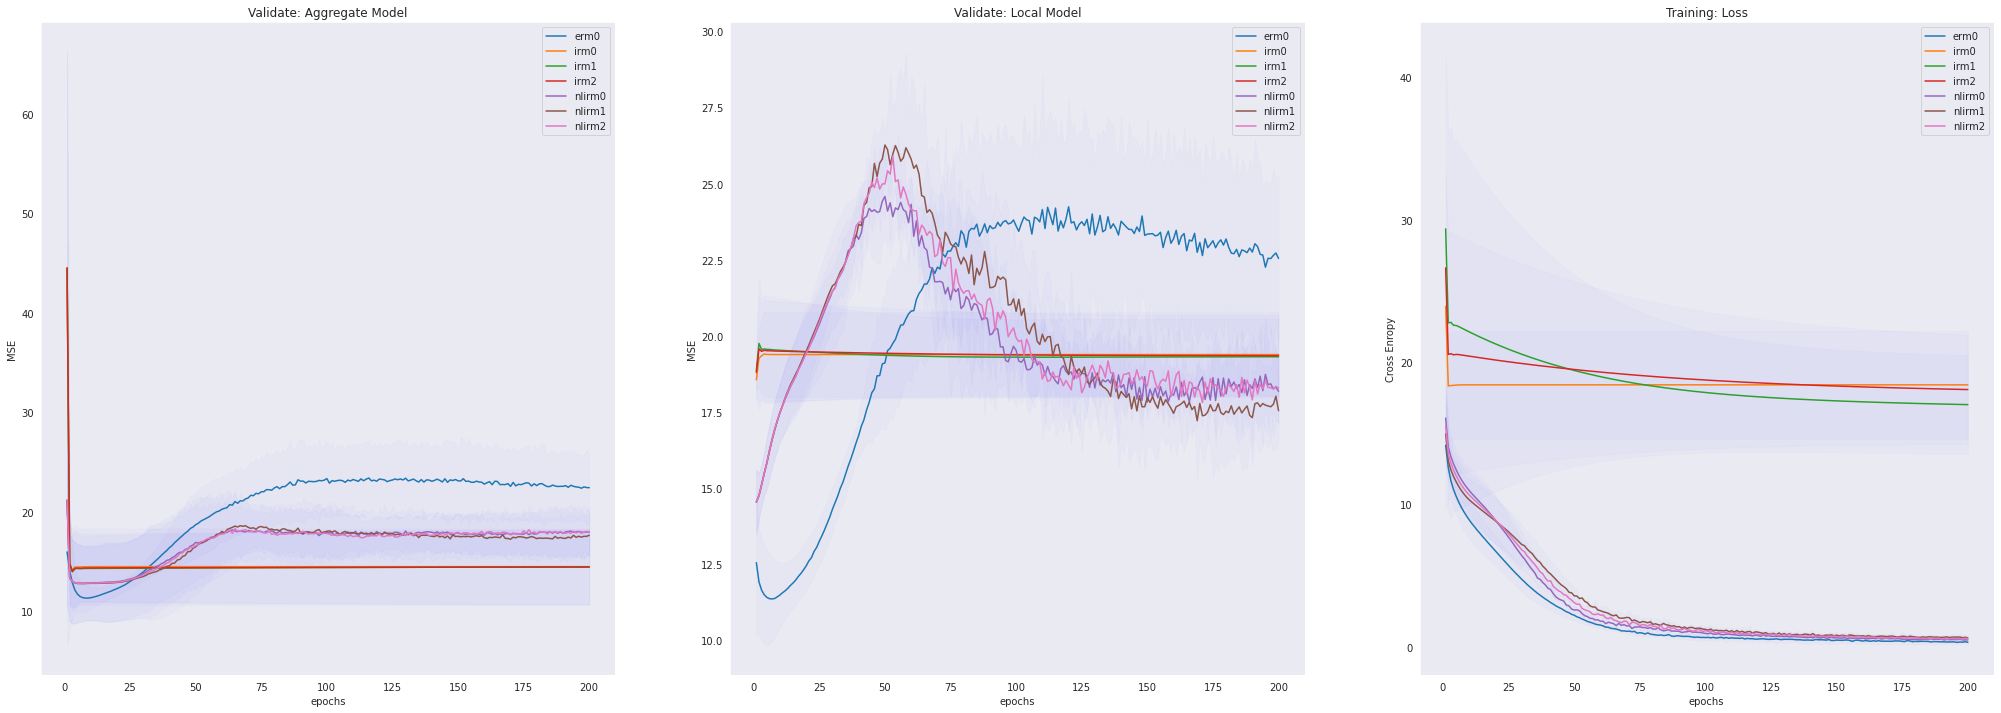

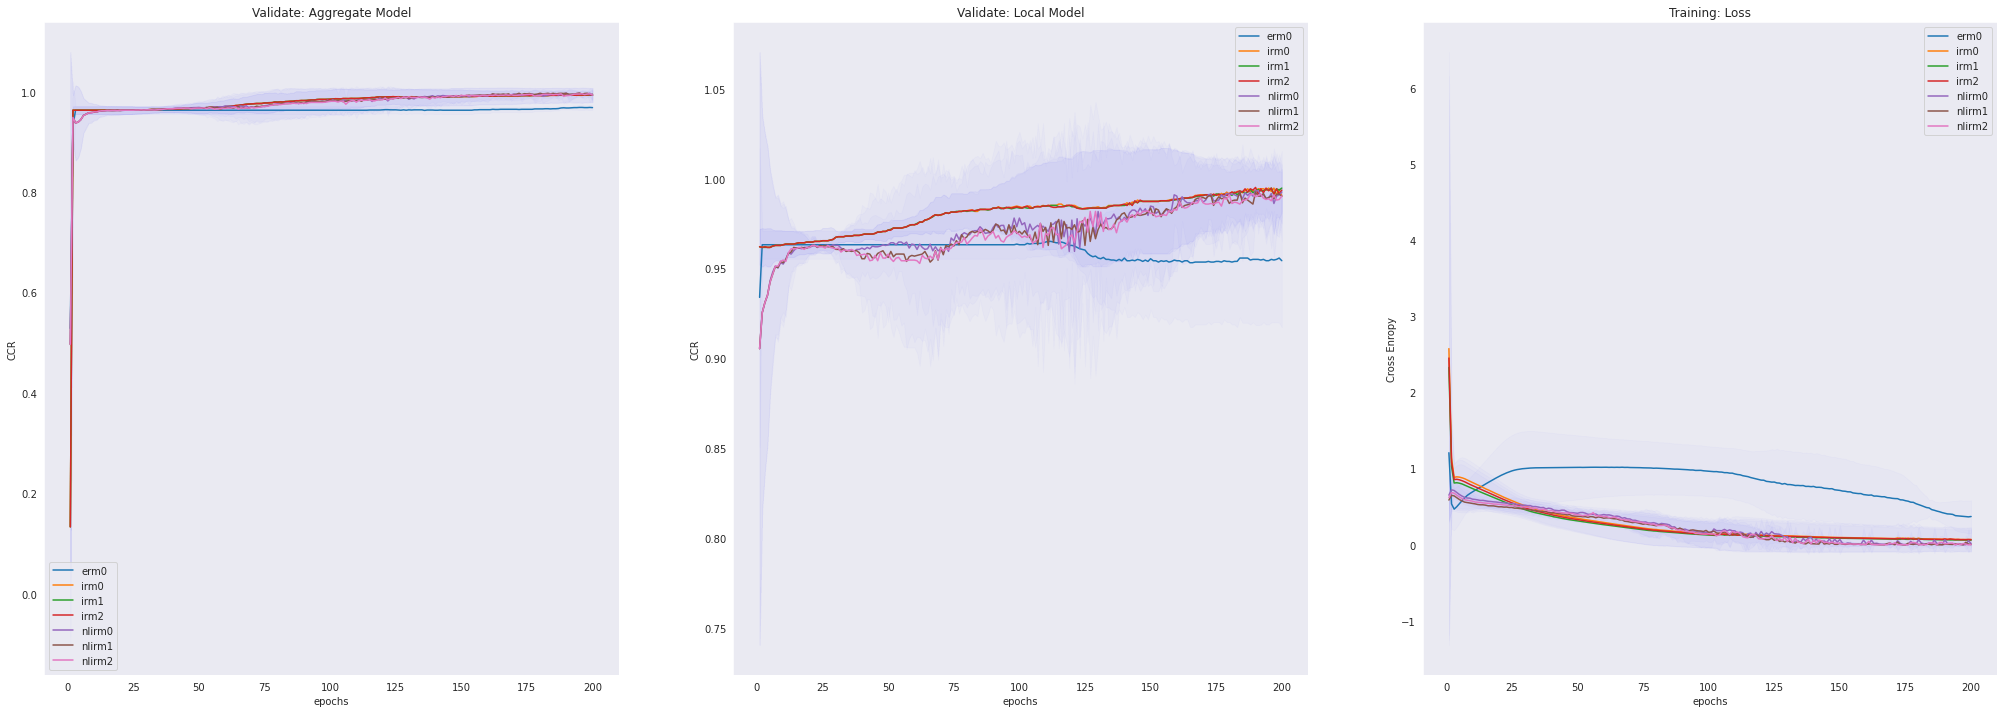

In [291]:
seed_subset = (90,94)
for case, experiment in presentation_runner.items():
    mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds(experiment[0], seed_subset, verbose = False)
    #consistent_n_batches = mean_dictionary[keys[0]].shape[0]
    plot_graphs(mean_dictionary, std_dictionary, keys, 200, experiment[1])

## Example 0a: simple regression

  0%|          | 0/30 [00:00<?, ?it/s]

number of sorted blobs =  30


100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


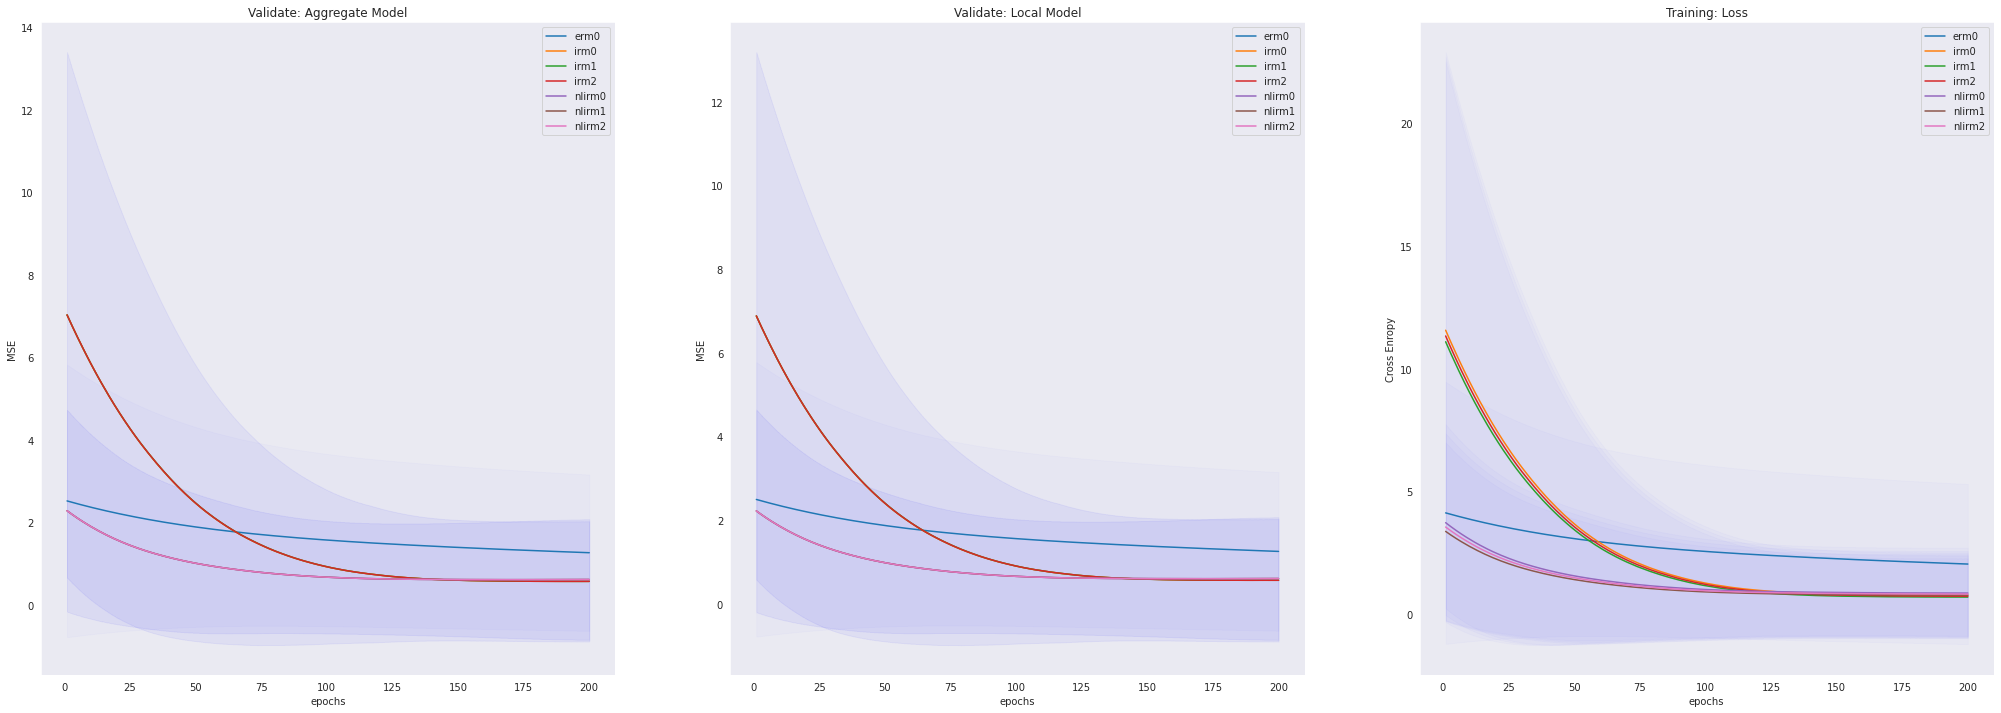

In [285]:
seed_subset = (0,30)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds('validation/Example0a_dim_inv_5_dim_spu_5_dim_unc_0_n_exp_3000_n_env_3' , seed_subset, verbose = False)
# consistent_n_batches = mean_dictionary[keys[0]].shape[0]

plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches = 200, metric =  "MSE")

## Example 0b: simple classification

  0%|          | 0/1 [00:00<?, ?it/s]

number of sorted blobs =  1


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


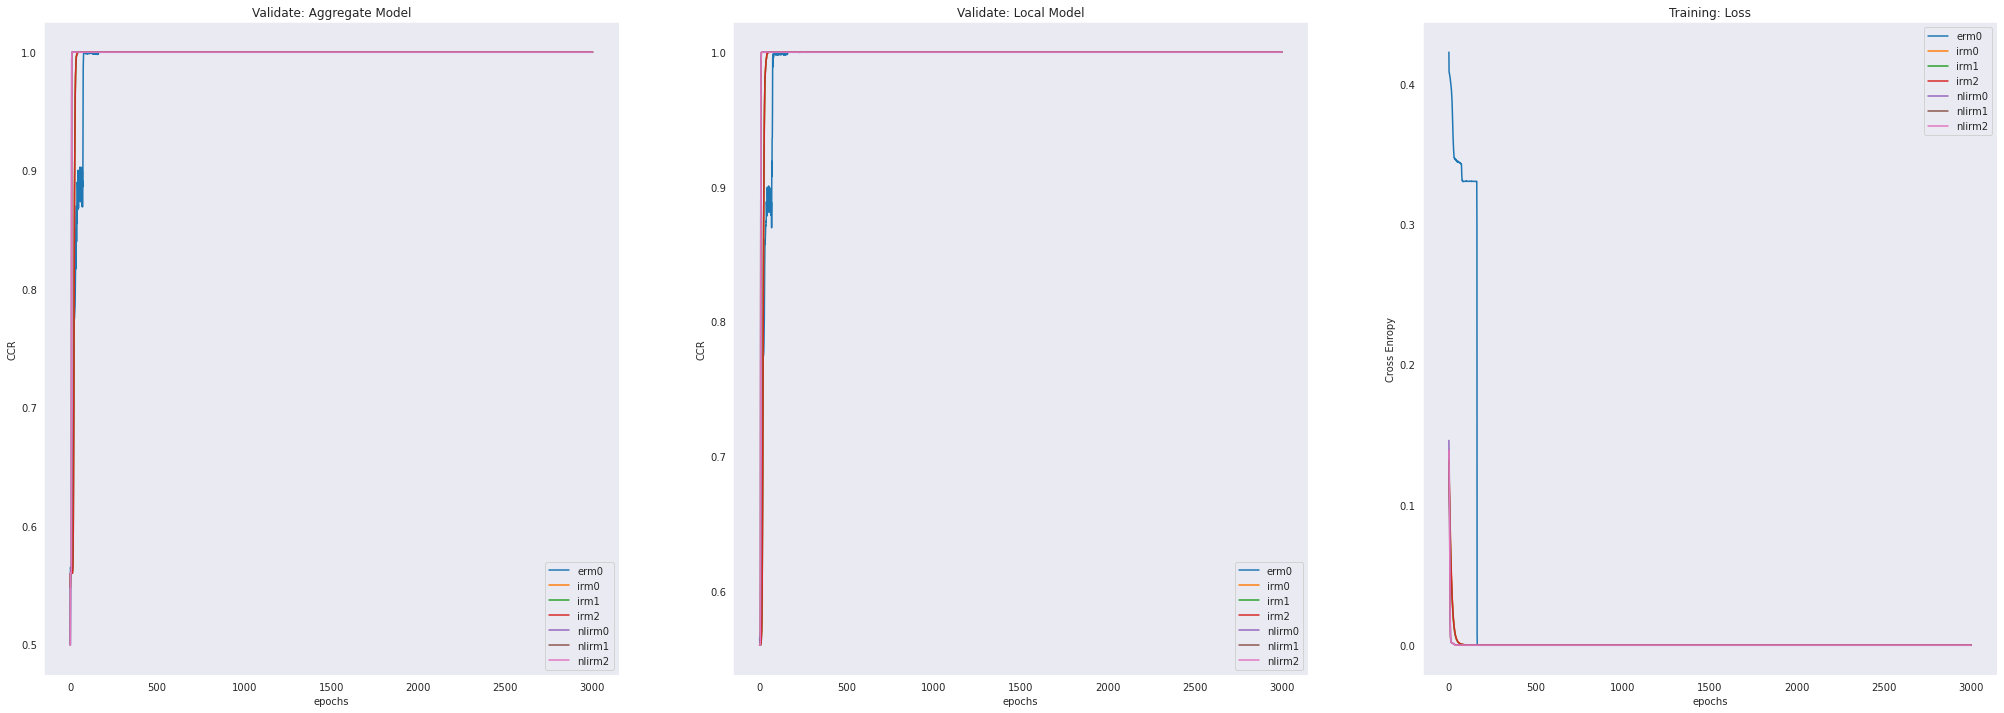

In [290]:
seed_subset = (90,91)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds('validation/Example0b_dim_inv_5_dim_spu_5_dim_unc_0_n_exp_3000_n_env_3' , seed_subset, verbose = False)
consistent_n_batches = mean_dictionary[keys[0]].shape[0]
plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches=3000, metric = "CCR")

## Example 1 (setting number = 1): regression

  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


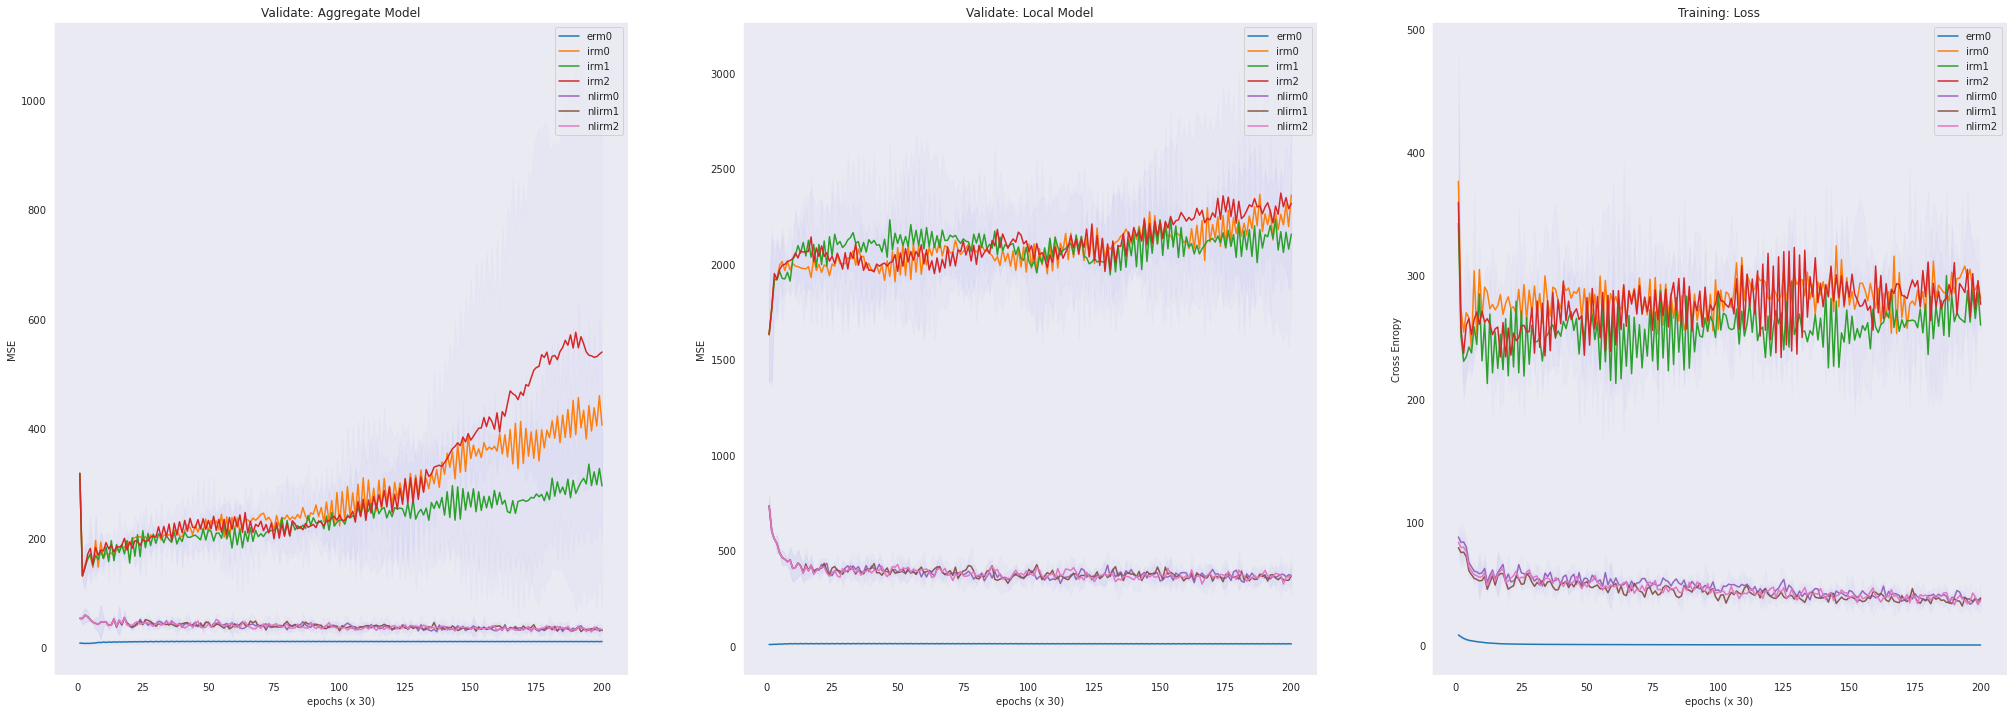

In [176]:
seed_subset = (0,30)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds('validation/Example1_dim_inv_6_dim_spu_6_dim_unc_500_n_exp_300_n_env_5' , seed_subset, verbose=False)
consistent_n_batches = mean_dictionary[keys[0]].shape[0]
plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches=200)

## Example 1 (setting number = 2): regression

  0%|          | 0/1 [00:00<?, ?it/s]

number of sorted blobs =  1


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


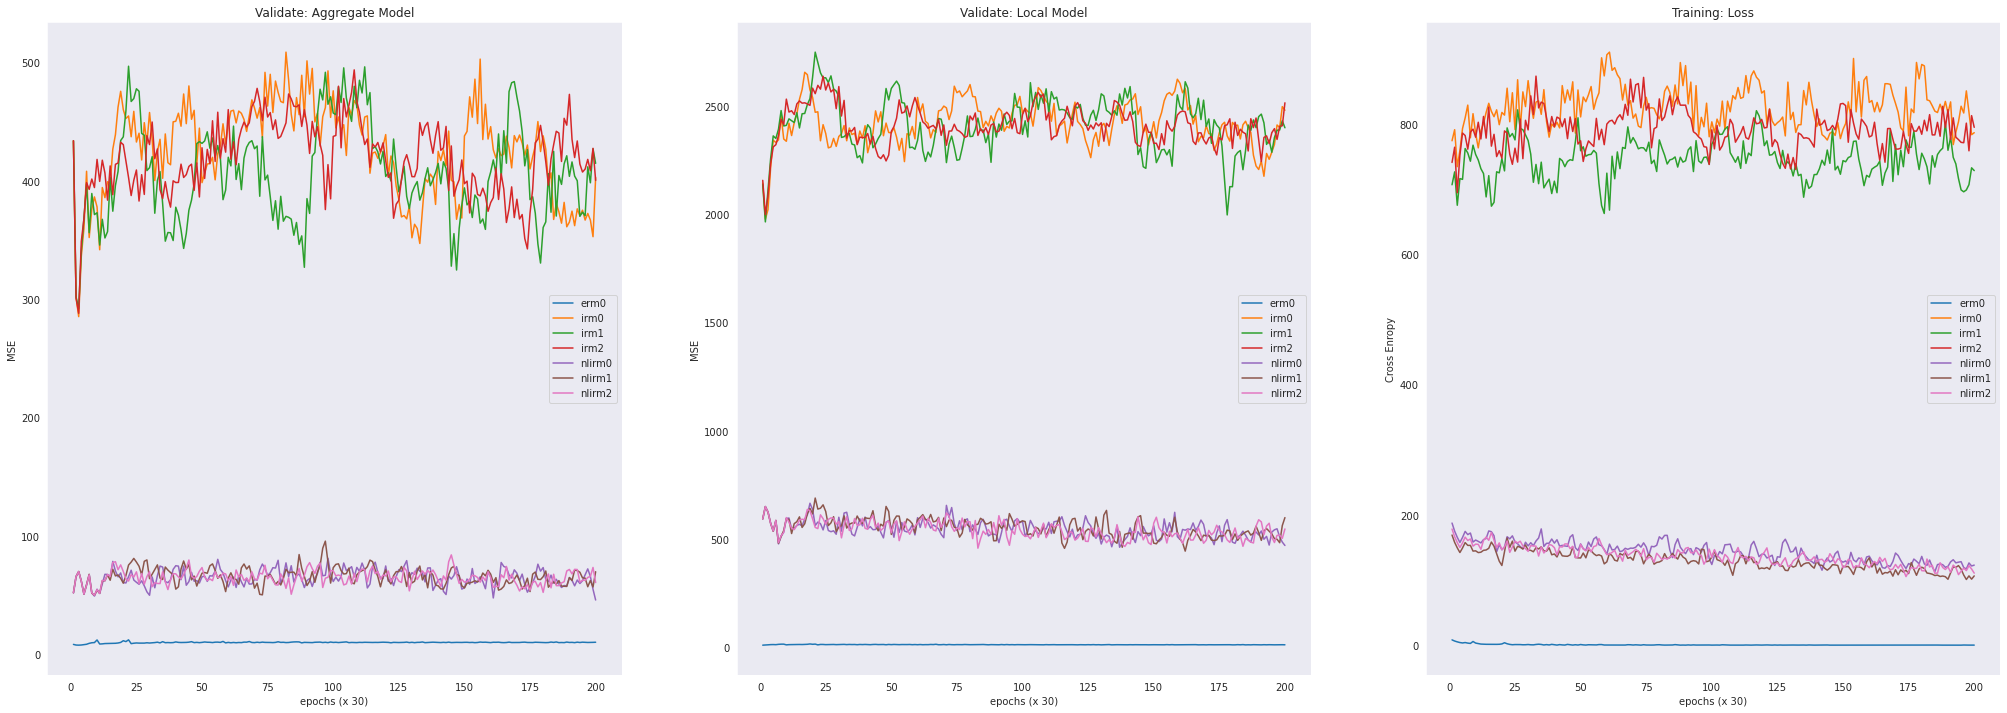

In [178]:
seed_subset = (0,2)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds('validation/Example1_dim_inv_6_dim_spu_6_dim_unc_500_n_exp_900_n_env_5' , seed_subset, verbose=False)
consistent_n_batches = mean_dictionary[keys[0]].shape[0]
plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches=200)

## Example 1 (setting number = 3): regression

In [ ]:
# seed_subset = (0,20)
# mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds('validation/Example1_dim_inv_6_dim_spu_6_dim_unc_50_n_exp_300_n_env_5', seed_subset, verbose=True)
# plot_graphs(mean_dictionary, std_dictionary, keys)

## Example 1 (setting number = 4): regression

  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


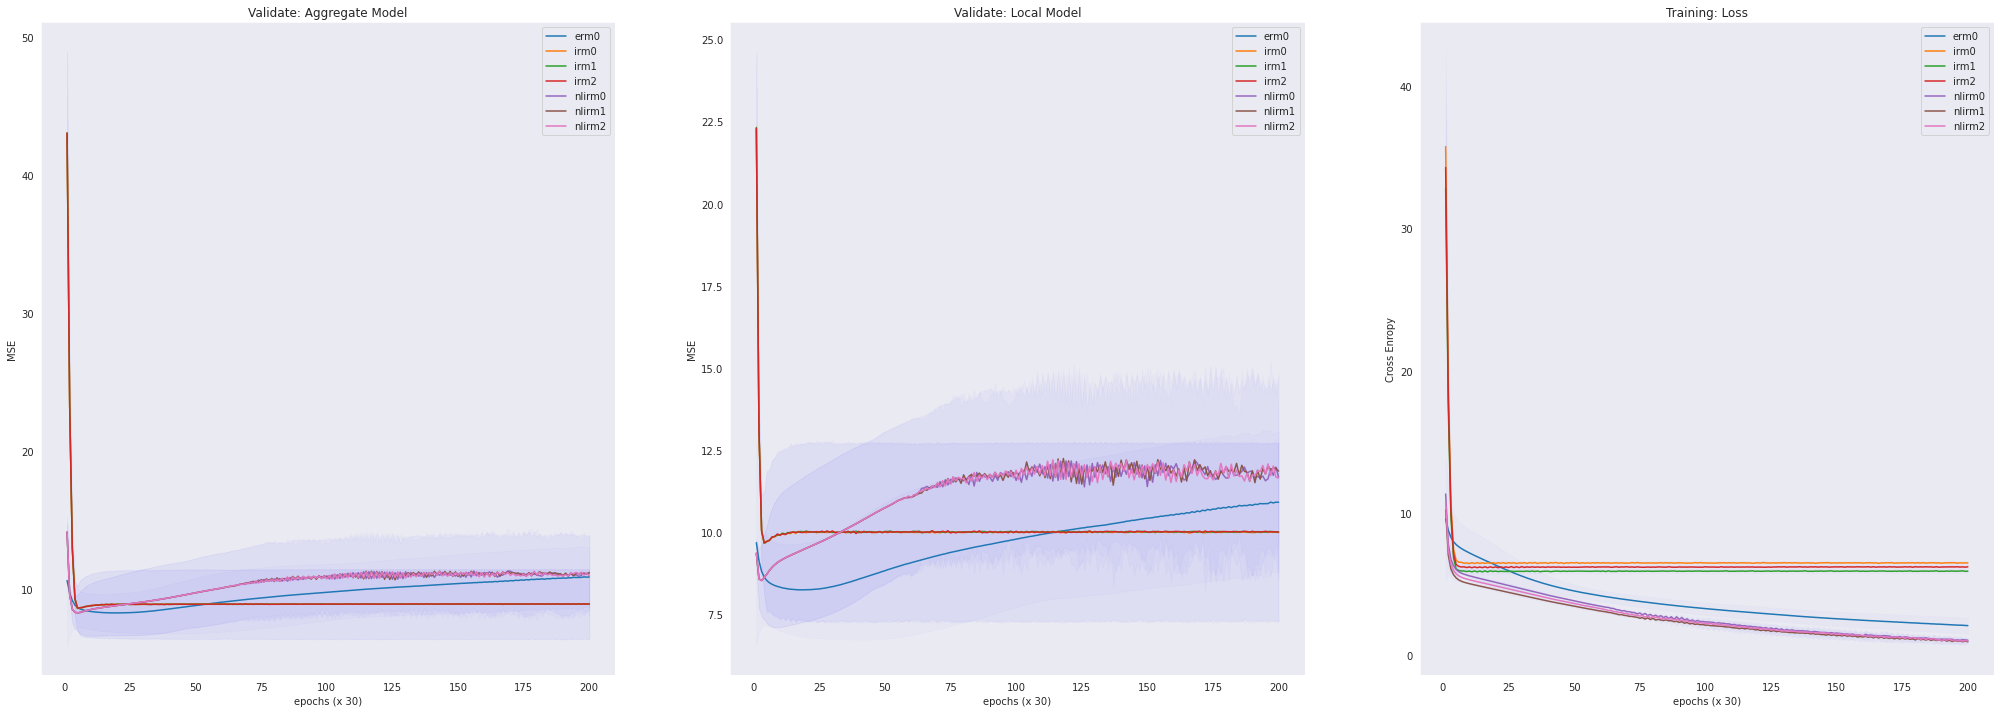

In [180]:
seed_subset = (0,2)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds('validation/Example1_dim_inv_6_dim_spu_6_dim_unc_50_n_exp_900_n_env_5', seed_subset, verbose=False)
consistent_n_batches = mean_dictionary[keys[0]].shape[0]
plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches=200)

## Multi-runner:

In [181]:
multi_runner = {
"1a": "validation/Example1_dim_inv_10_dim_spu_500_dim_unc_0_n_exp_300_n_env_5/", 
"1b": "validation/Example1_dim_inv_10_dim_spu_500_dim_unc_0_n_exp_900_n_env_5/",
"1c": "validation/Example1_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_300_n_env_5/",
"1d": "validation/Example1_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_900_n_env_5/",

"2a": "validation/Example2_dim_inv_10_dim_spu_500_dim_unc_0_n_exp_300_n_env_5/", 
"2b": "validation/Example2_dim_inv_10_dim_spu_500_dim_unc_0_n_exp_900_n_env_5/",
"2c": "validation/Example2_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_300_n_env_5/",
"2d": "validation/Example2_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_900_n_env_5/"
}



 1a: validation/Example1_dim_inv_10_dim_spu_500_dim_unc_0_n_exp_300_n_env_5/


  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]



 1b: validation/Example1_dim_inv_10_dim_spu_500_dim_unc_0_n_exp_900_n_env_5/


  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]



 1c: validation/Example1_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_300_n_env_5/


  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]



 1d: validation/Example1_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_900_n_env_5/


  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]



 2a: validation/Example2_dim_inv_10_dim_spu_500_dim_unc_0_n_exp_300_n_env_5/


  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]



 2b: validation/Example2_dim_inv_10_dim_spu_500_dim_unc_0_n_exp_900_n_env_5/


  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]



 2c: validation/Example2_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_300_n_env_5/


  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]



 2d: validation/Example2_dim_inv_10_dim_spu_50_dim_unc_0_n_exp_900_n_env_5/


  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


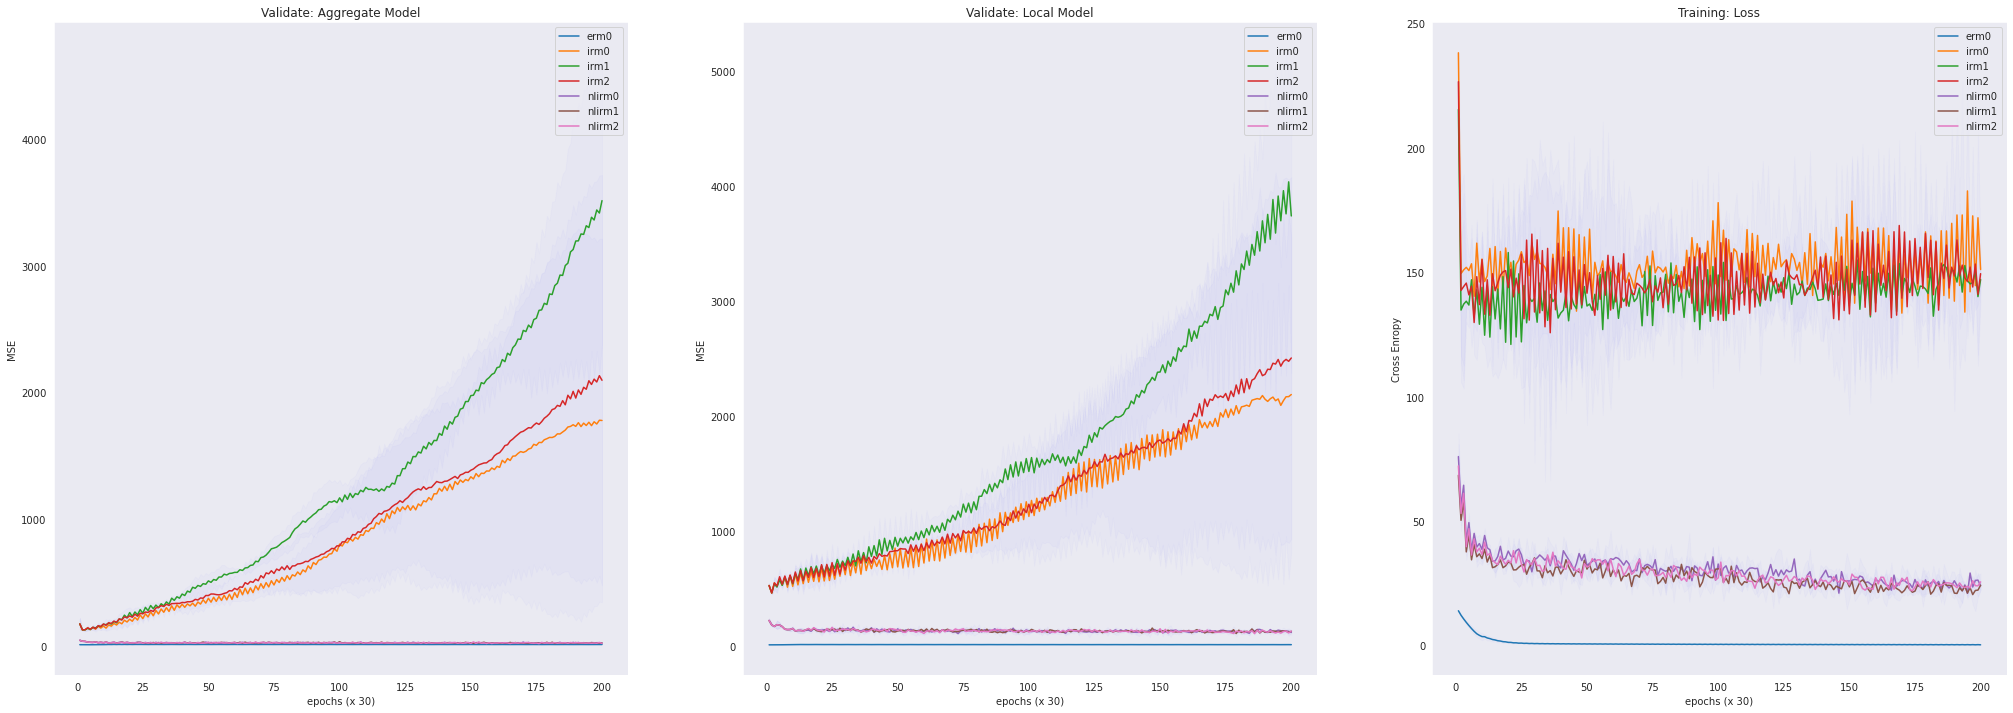

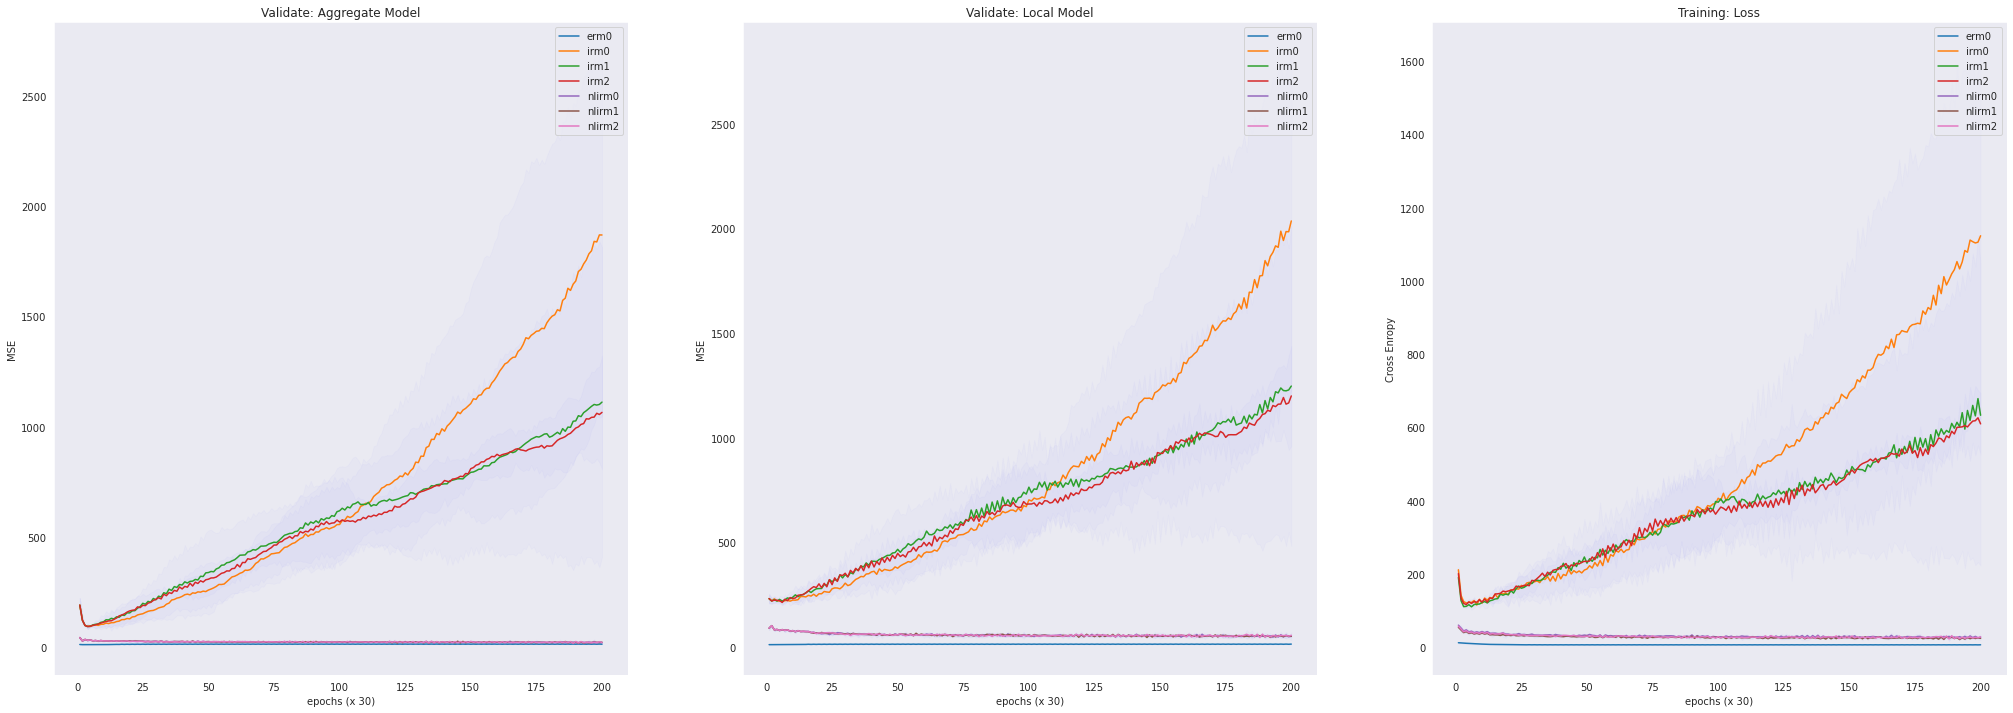

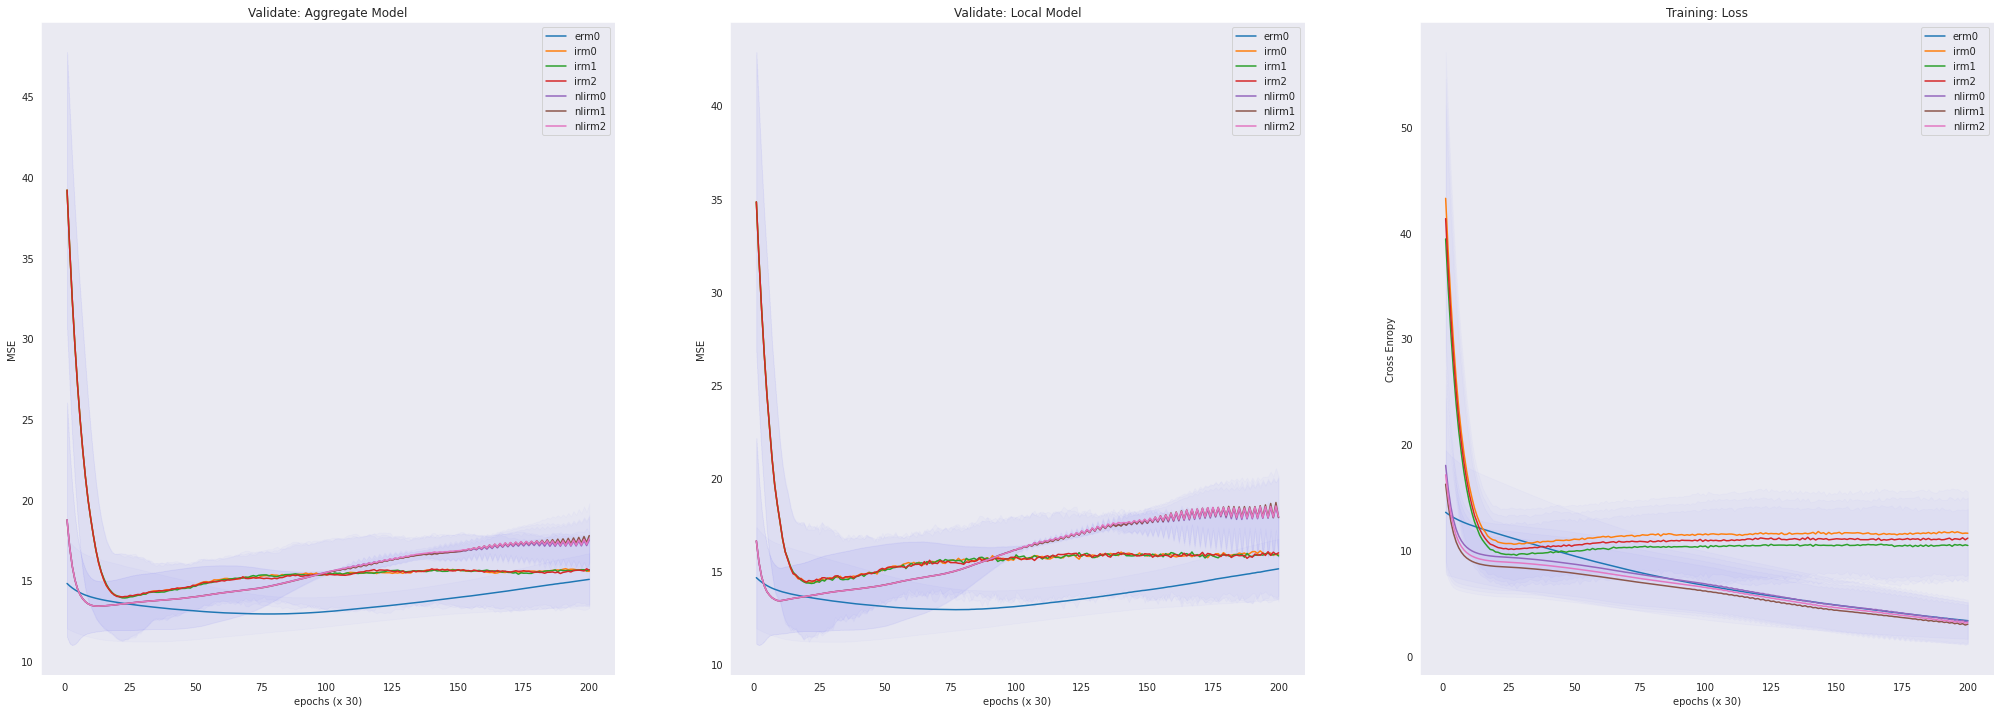

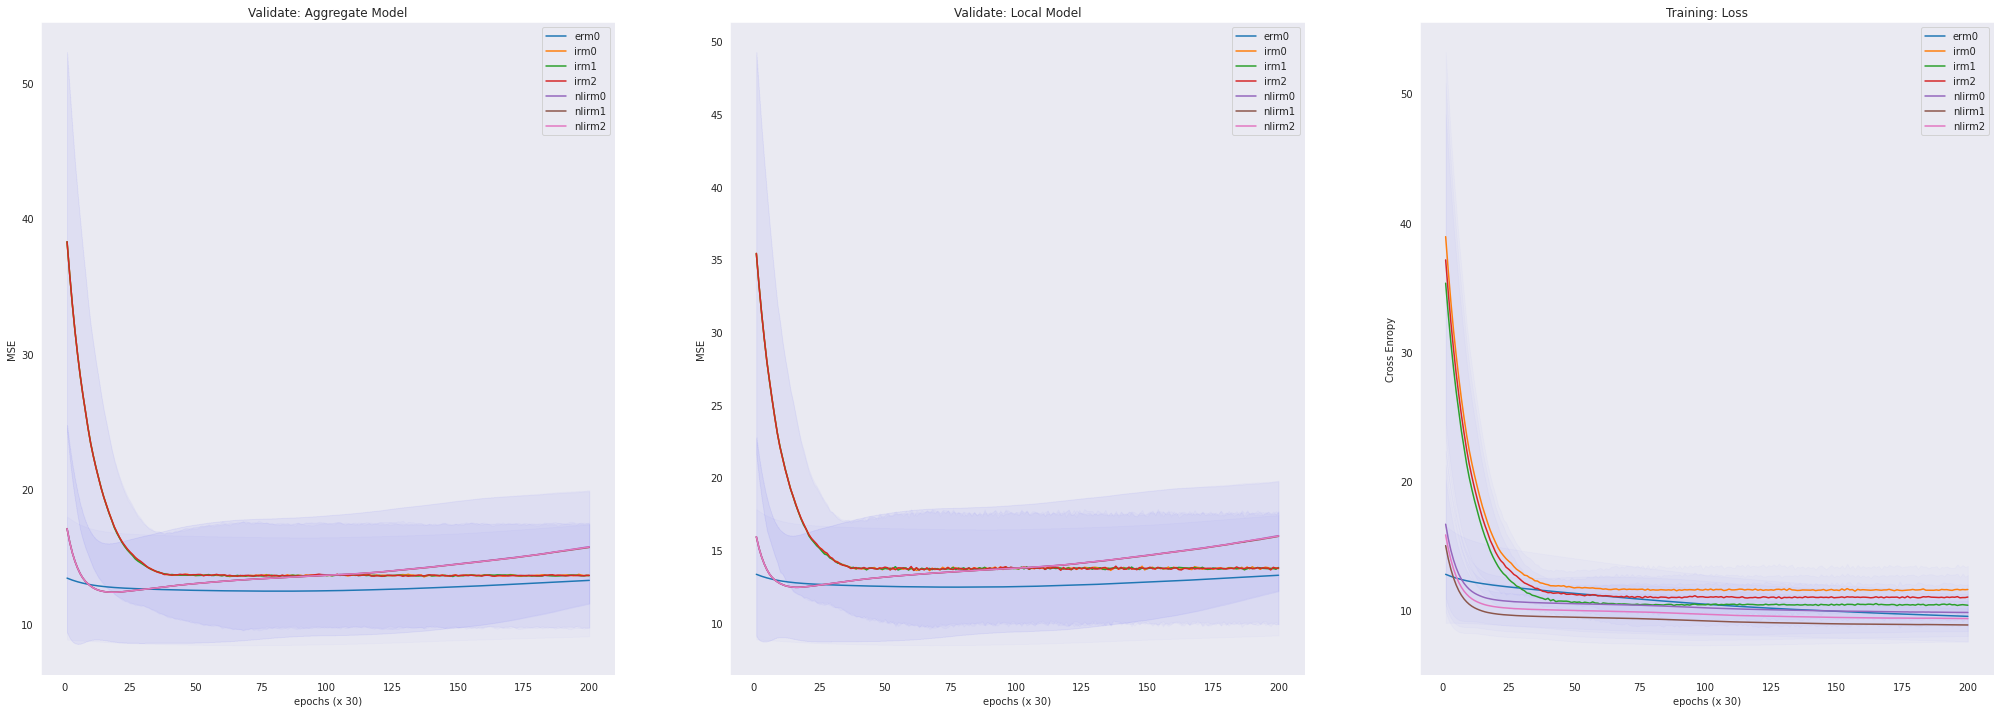

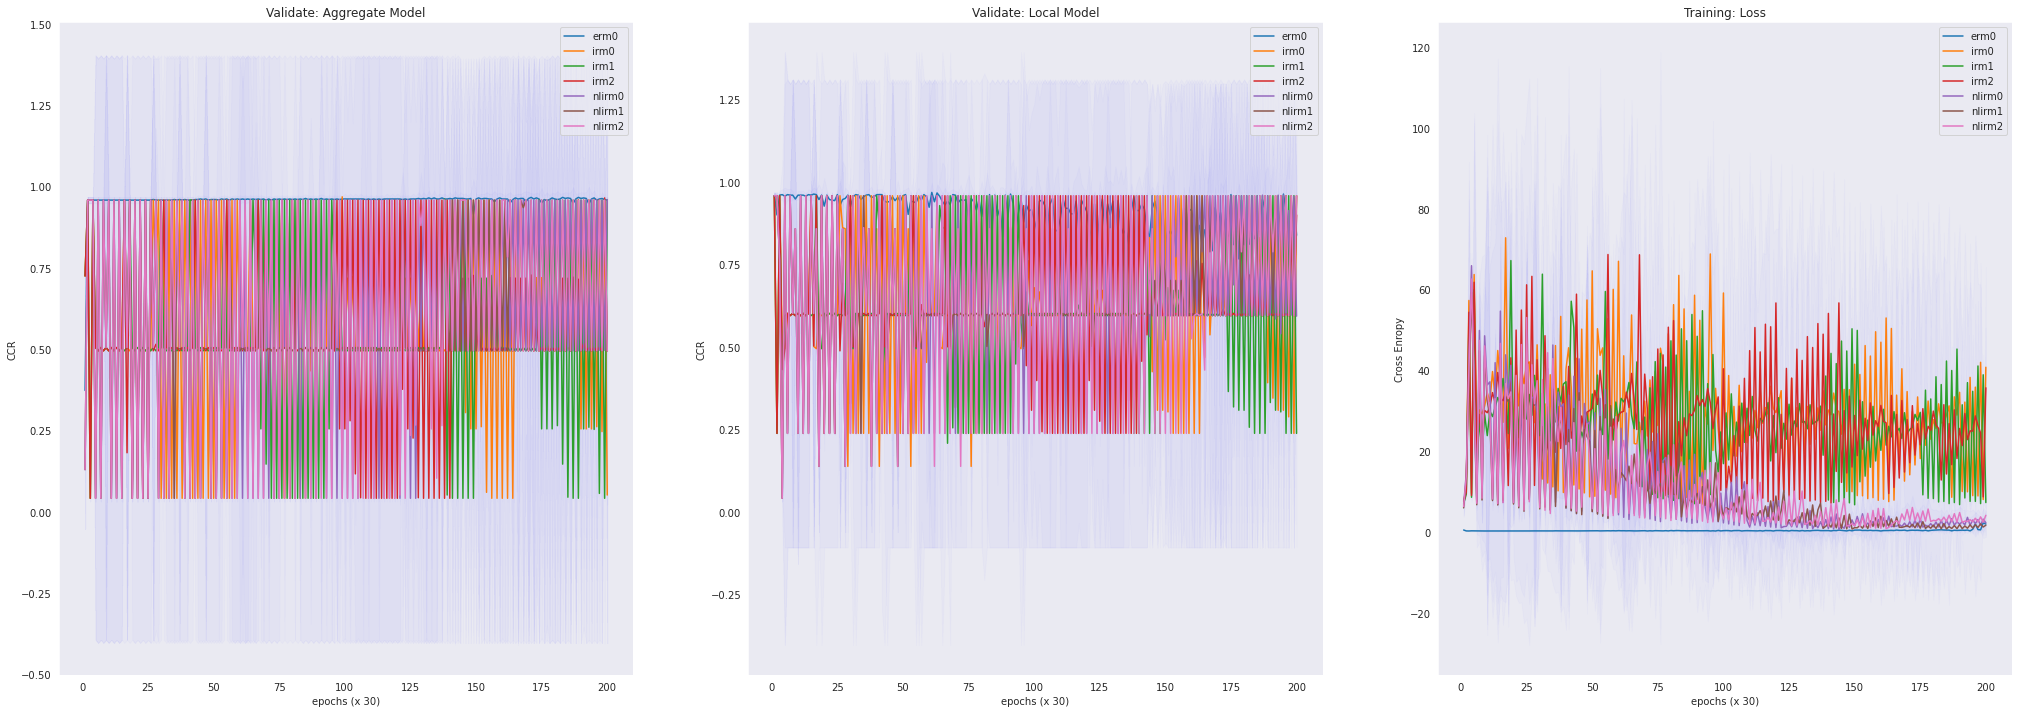

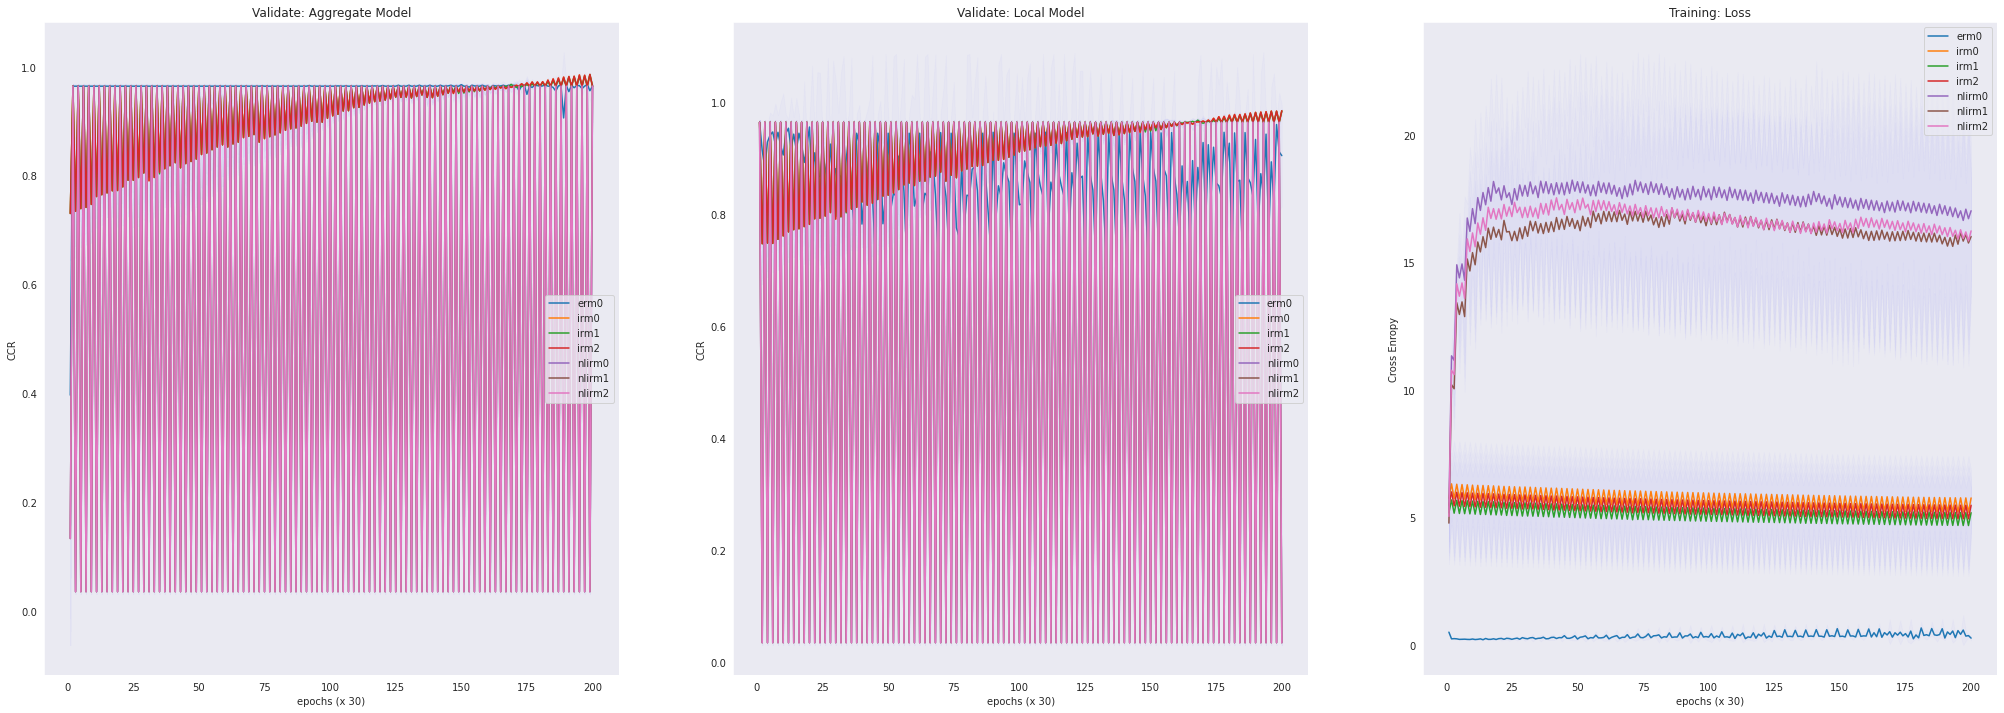

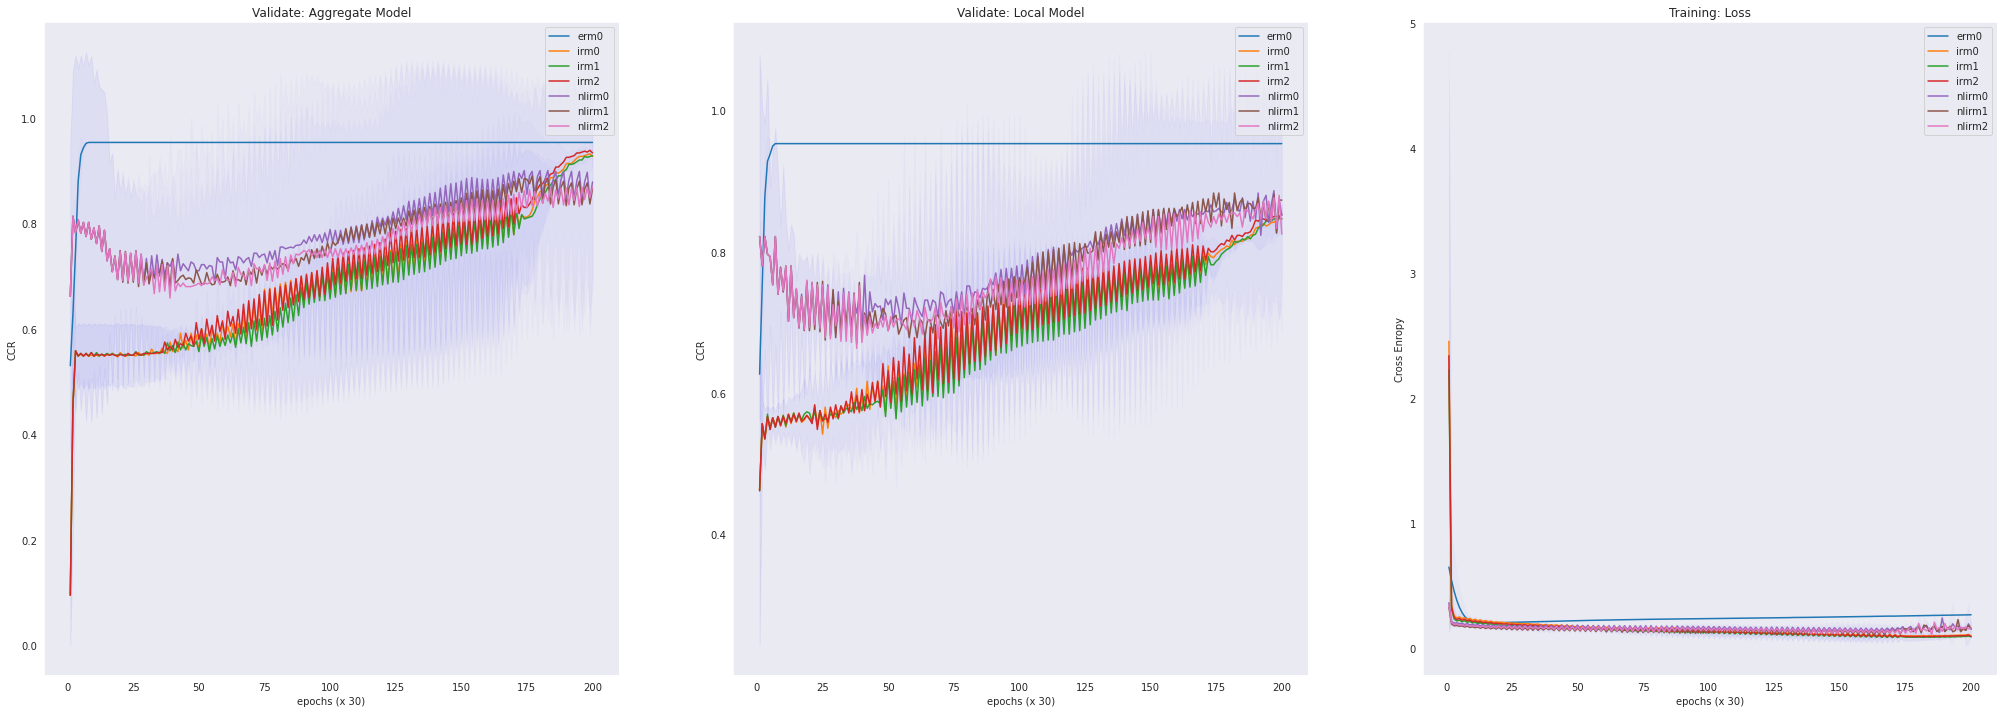

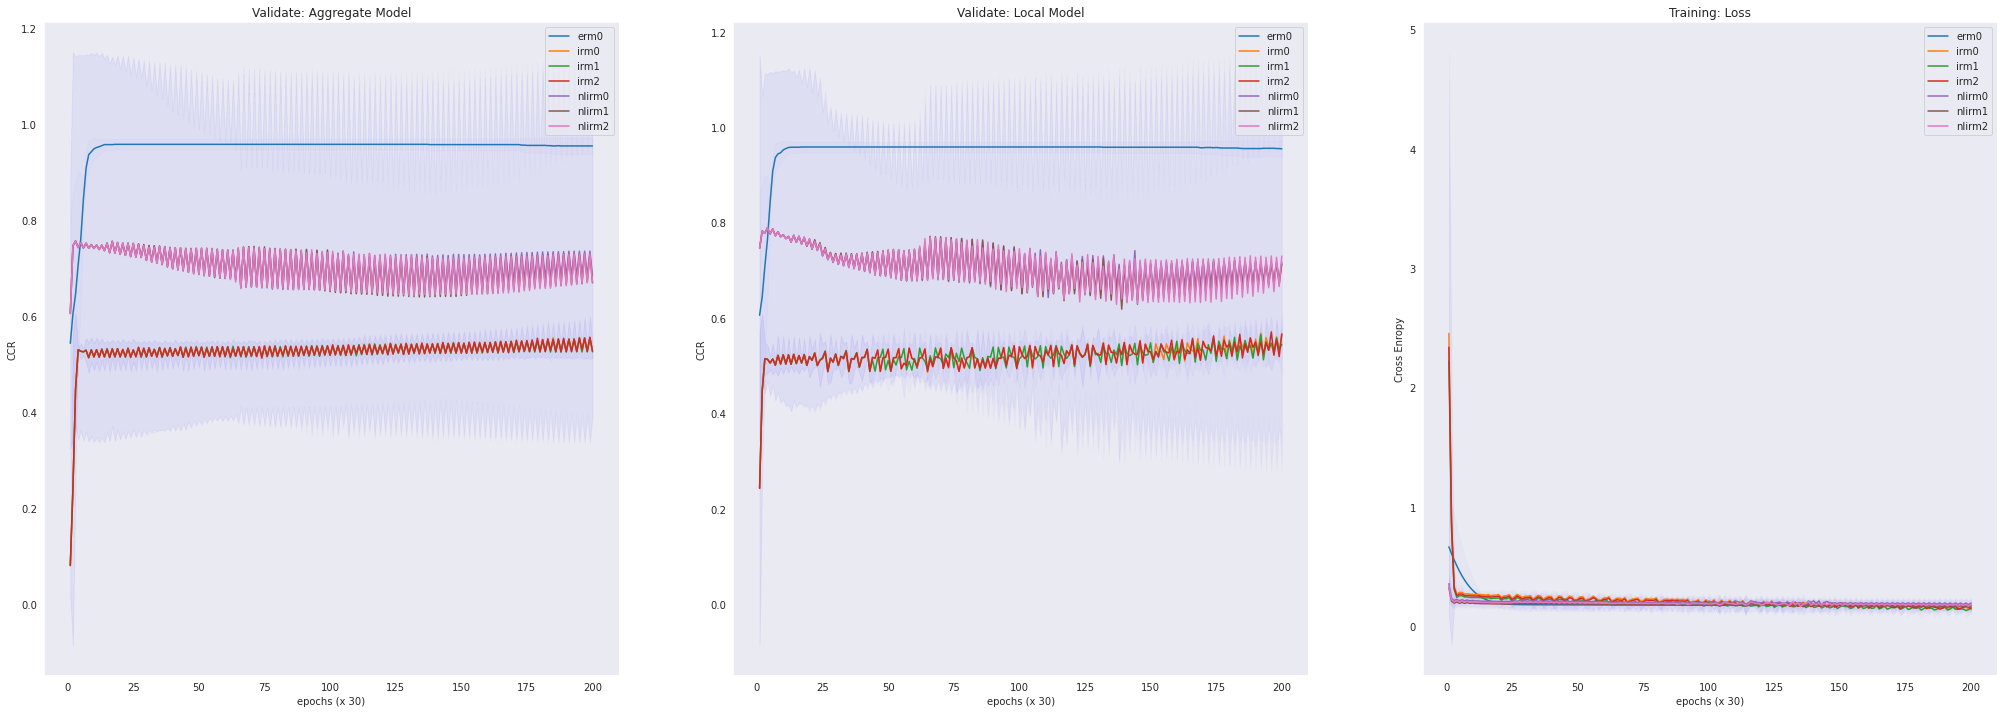

In [182]:
seed_subset = (0,2)
for name, exp_path in multi_runner.items():
    print("\n %s: %s" % (name, exp_path))
    mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds(exp_path, seed_subset, verbose=False)
    consistent_n_batches = mean_dictionary[keys[0]].shape[0]
    
    metric="MSE"
    if "2" in name: metric = "CCR"
    plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches, metric=metric)

## Elijah Datasets
- 6 collaborators
- 12 collaborators

  0%|          | 0/2 [00:00<?, ?it/s]

number of sorted blobs =  2


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


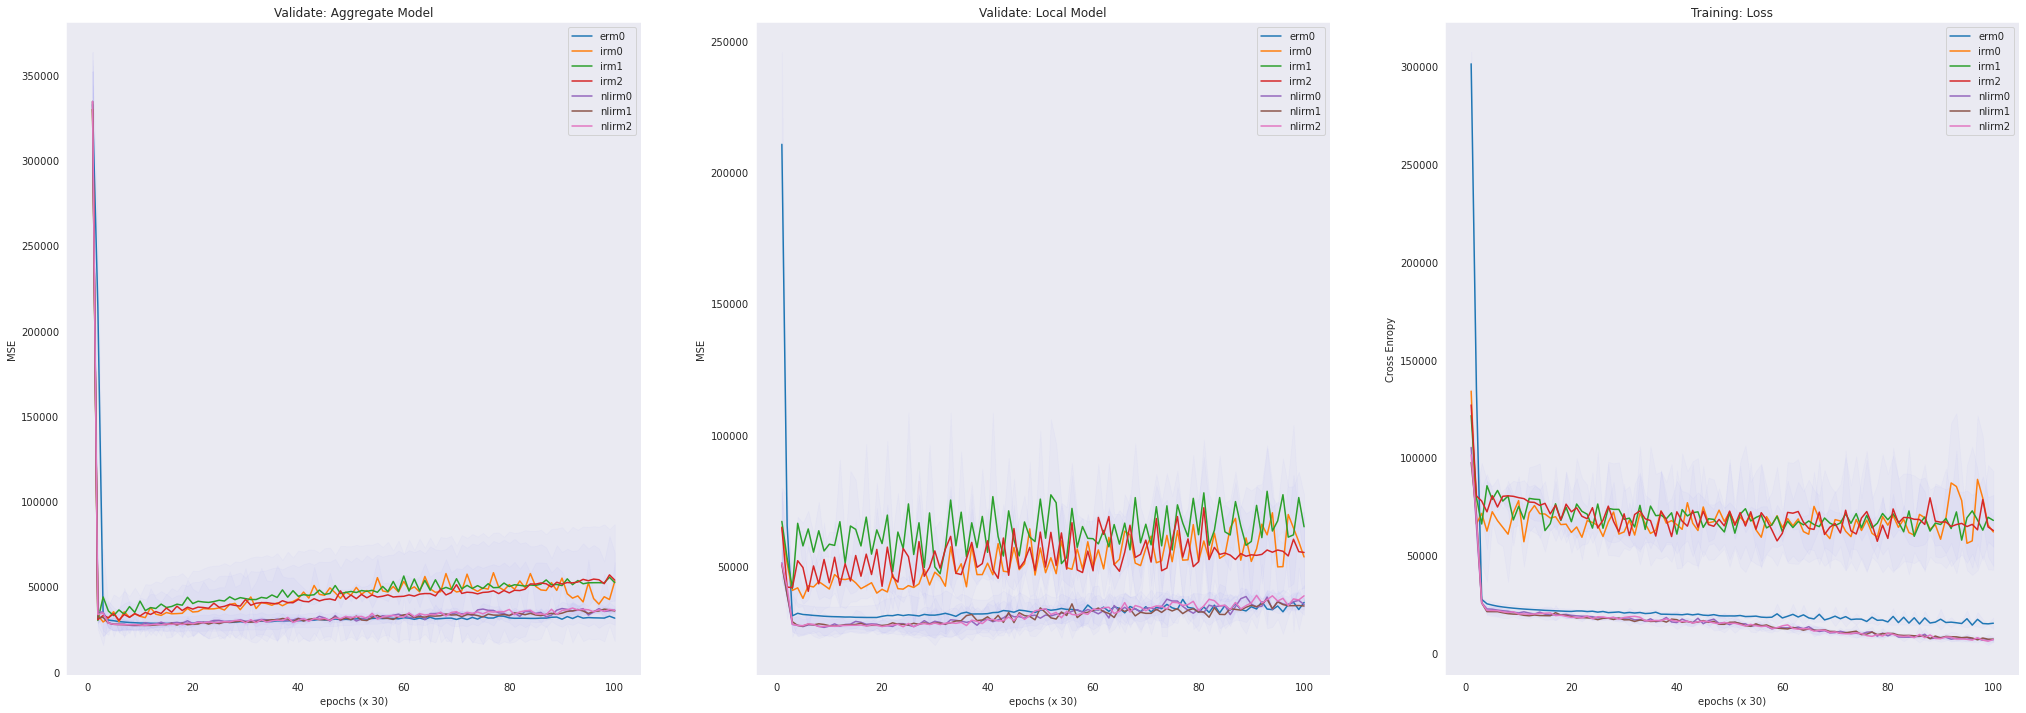

In [184]:
seed_subset = (0,2)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds("elijah_mouse_experiment_reduced_new_code_v5", seed_subset, verbose=False)
consistent_n_batches = mean_dictionary[keys[0]].shape[0]

plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches)



  0%|          | 0/4 [00:00<?, ?it/s]

number of sorted blobs =  4


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


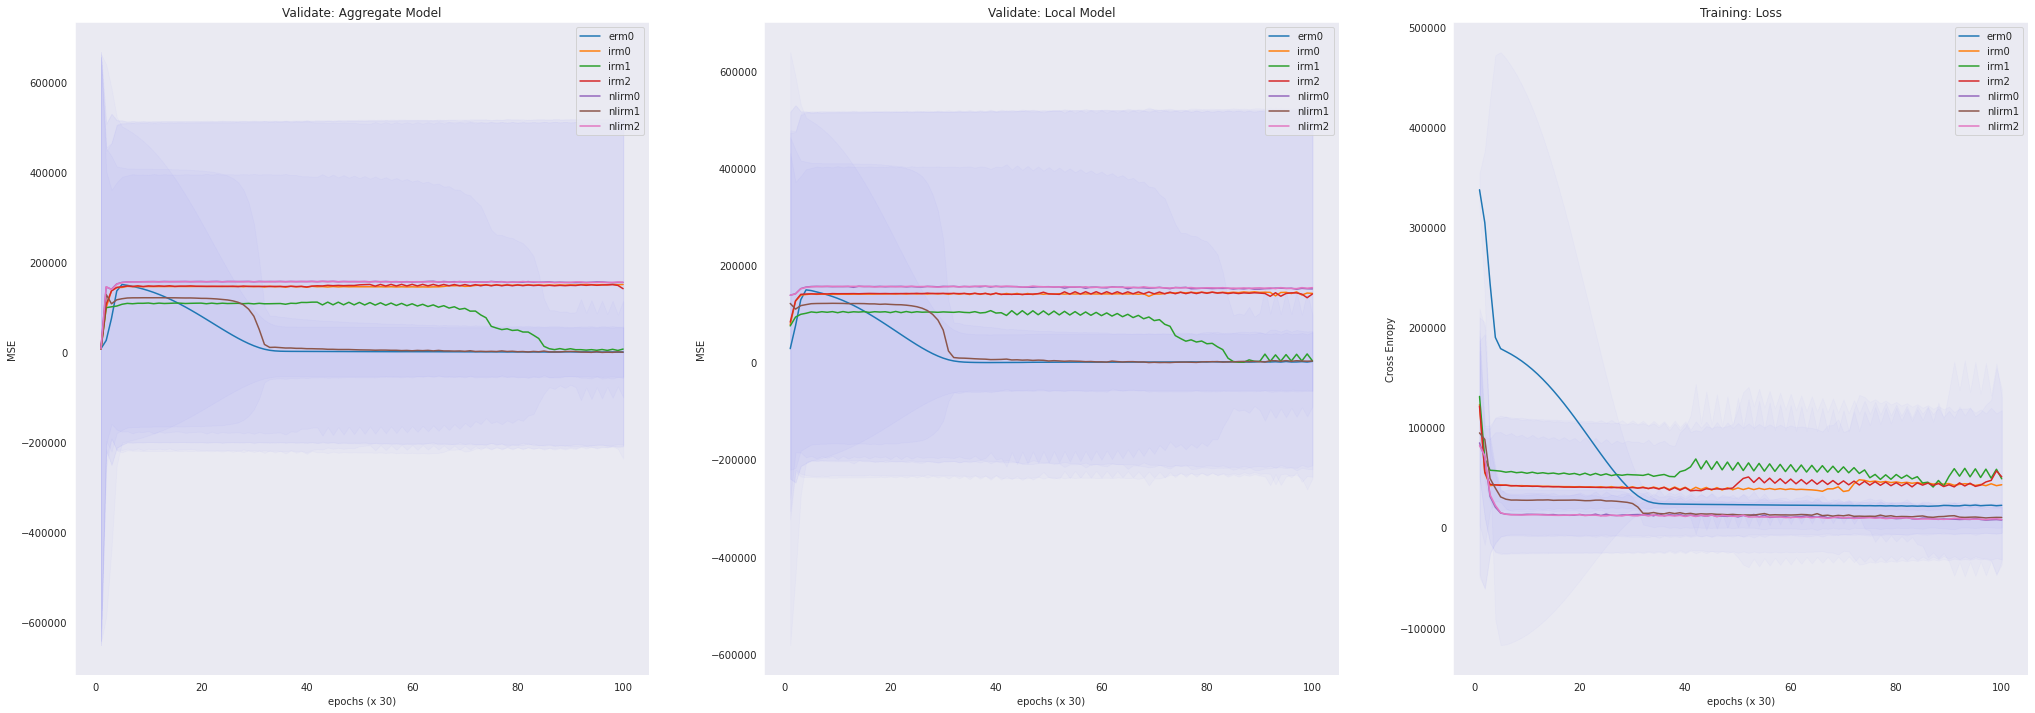

In [190]:
seed_subset = (0,5)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds('Final_elijah_mouse_experiment_reduced_12_env_mode', seed_subset)
consistent_n_batches = mean_dictionary[keys[0]].shape[0]

plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches)

  0%|          | 0/3 [00:00<?, ?it/s]

number of sorted blobs =  3


100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


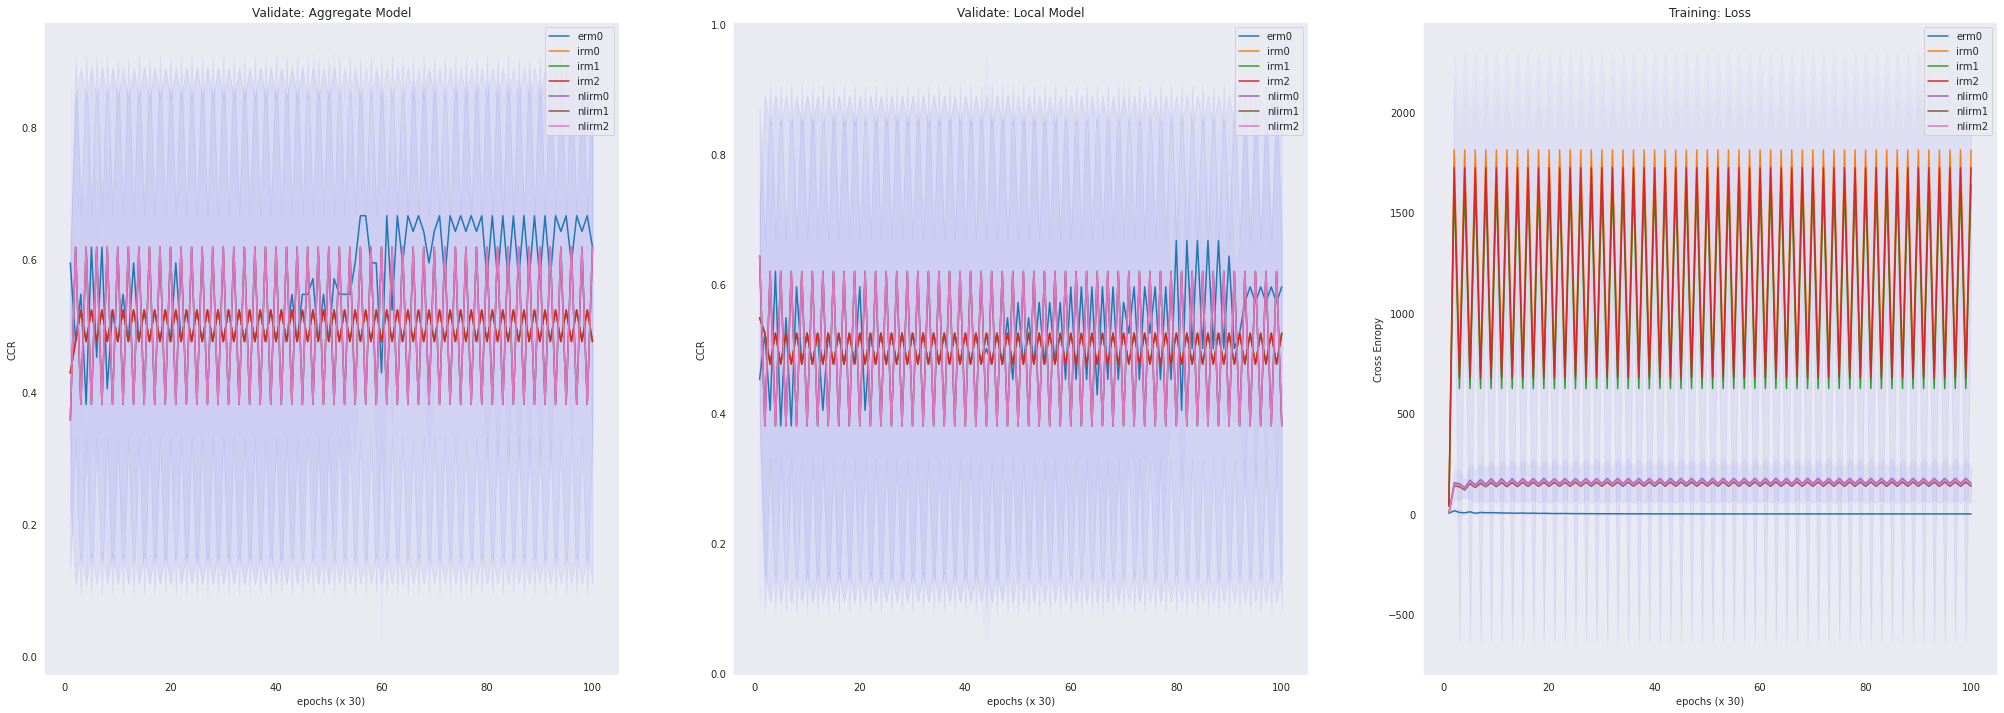

In [189]:
seed_subset = (0,4)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds("heavy_ion_experiment_reduced_new_code", seed_subset, verbose=False)
consistent_n_batches = mean_dictionary[keys[0]].shape[0]

plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches, metric = "CCR")

## Gamma Ray: 

  0%|          | 0/1 [00:00<?, ?it/s]

number of sorted blobs =  1


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


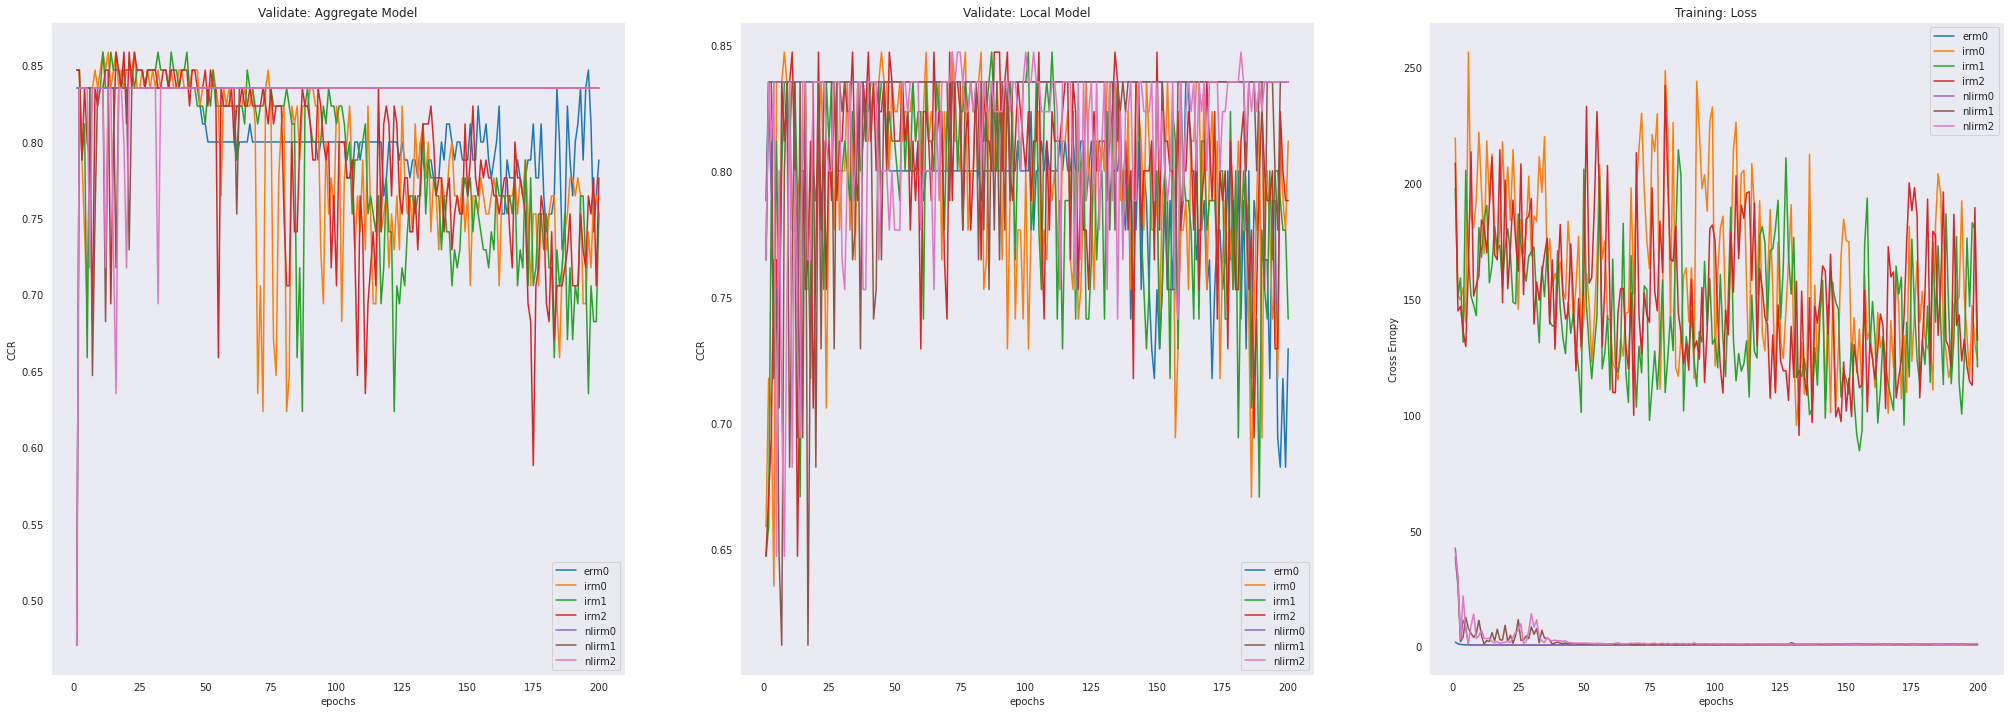

In [292]:
seed_subset = (0,10)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds("final_gamma_ray_experiment_reduced", seed_subset, verbose=False)
consistent_n_batches = mean_dictionary[keys[0]].shape[0]
plot_graphs(mean_dictionary, std_dictionary, keys, consistent_n_batches, metric = "CCR")